In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os

import numpy as np

In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
labels = ['Organic','Recyclable']
img_size = 224
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [4]:
train = get_data('/content/drive/MyDrive/WasteClassification/DATASET/DATASET/TRAIN')
test = get_data('/content/drive/MyDrive/WasteClassification/DATASET/DATASET/TEST')

<ipython-input-3-2da2156c6d3e>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


Text(0.5, 1.0, 'Organic')

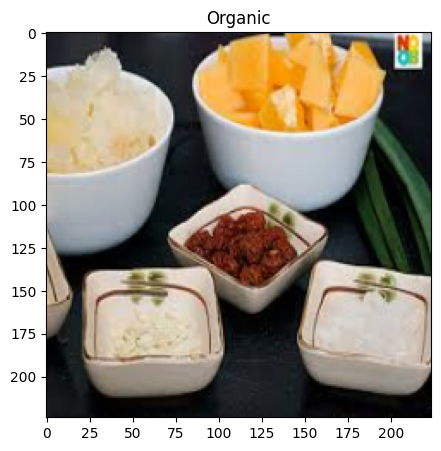

In [5]:
plt.figure(figsize = (5,5))
plt.imshow(train[1][0])
plt.title(labels[train[0][1]])

Text(0.5, 1.0, 'Recyclable')

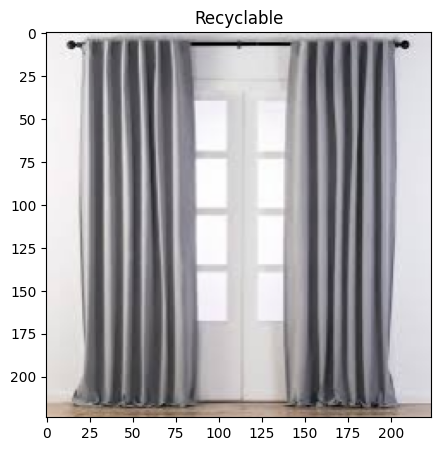

In [6]:
plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])

In [7]:
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in test:
  x_val.append(feature)
  y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [8]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [9]:
datagen.fit(x_train)

In [10]:
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(224,224,3),
    alpha=1.0,
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax',
)

# Add a global average pooling layer
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Add a fully connected layer with one neuron for binary classification
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Combine the base model and the custom classification layers
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

9406464/9406464 [==============================] - 0s 0us/step


In [11]:
# Train the model
history = model.fit(x_train, y_train, epochs=15, steps_per_epoch=8, validation_data=(x_val, y_val), verbose=1)


# Save the trained model
base_model.save('MobileNet.h5')

Epoch 1/15
8/8 [==============================] - 134s 17s/step - loss: 0.7949 - accuracy: 0.5190 - val_loss: 0.6289 - val_accuracy: 0.6450
Epoch 2/15
8/8 [==============================] - 125s 16s/step - loss: 0.5880 - accuracy: 0.6895 - val_loss: 0.4987 - val_accuracy: 0.7920
Epoch 3/15
8/8 [==============================] - 170s 23s/step - loss: 0.4574 - accuracy: 0.8015 - val_loss: 0.4134 - val_accuracy: 0.8500
Epoch 4/15
8/8 [==============================] - 131s 17s/step - loss: 0.3788 - accuracy: 0.8455 - val_loss: 0.3703 - val_accuracy: 0.8640
Epoch 5/15
8/8 [==============================] - 131s 17s/step - loss: 0.3296 - accuracy: 0.8775 - val_loss: 0.3335 - val_accuracy: 0.8830
Epoch 6/15
8/8 [==============================] - 172s 23s/step - loss: 0.2988 - accuracy: 0.8920 - val_loss: 0.3194 - val_accuracy: 0.8810
Epoch 7/15
8/8 [==============================] - 128s 17s/step - loss: 0.2775 - accuracy: 0.9005 - val_loss: 0.3113 - val_accuracy: 0.8770
Epoch 8/15
8/8 [====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [15]:
epochs_range = range(15)

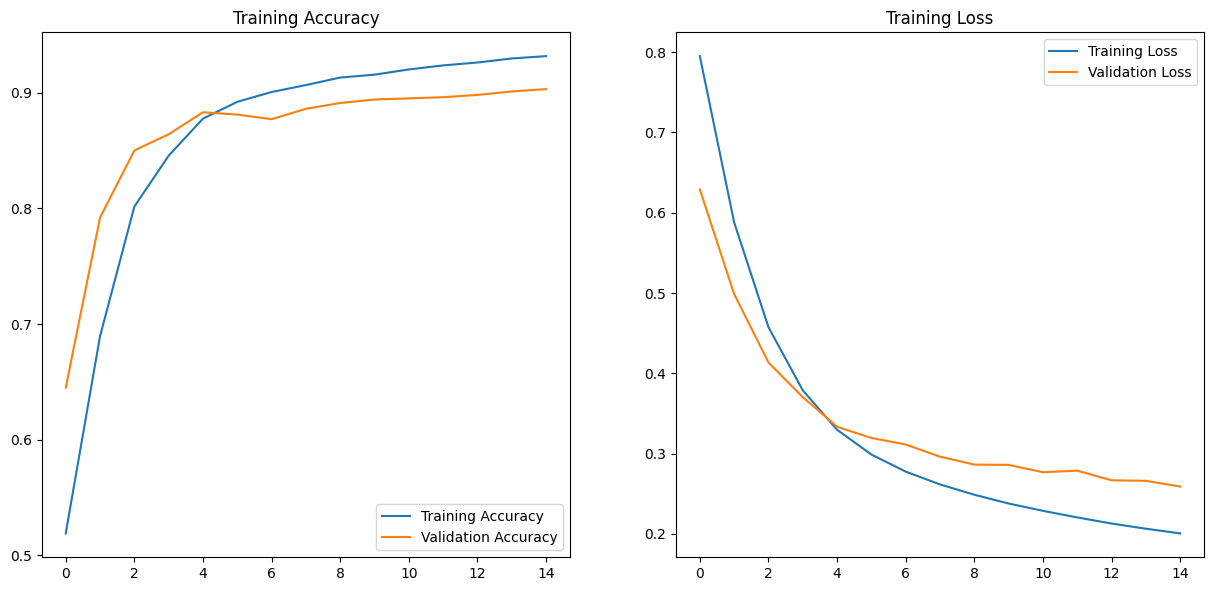

In [16]:
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

In [17]:
import tensorflow as tf
import numpy as np
from PIL import Image

In [18]:
predict= model.predict(x_val)
#print(predict)
predictions=(predict > 0.5).astype("int32")
#print(predictions)
predictions = predictions.reshape(1,-1)[0]
print(predictions)
#print(classification_report(y_val, predictions, target_names = ['Organic (Class 0)','Recyclable (Class 1)']))

32/32 [==============================] - 40s 1s/step
[0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 

In [19]:
print(classification_report(y_val, predictions, target_names = ['Organic (Class 0)','Recyclable (Class 1)']))

                      precision    recall  f1-score   support

   Organic (Class 0)       0.87      0.95      0.91       500
Recyclable (Class 1)       0.94      0.86      0.90       500

            accuracy                           0.90      1000
           macro avg       0.91      0.90      0.90      1000
        weighted avg       0.91      0.90      0.90      1000



In [20]:

true_labels = y_val
predicted_labels=predictions

TP = np.sum((predicted_labels == 1) & (true_labels == 1))
TN = np.sum((predicted_labels == 0) & (true_labels == 0))
FP = np.sum((predicted_labels == 1) & (true_labels == 0))
FN = np.sum((predicted_labels == 0) & (true_labels == 1))

print(TP,TN,FP,FN)

430 473 27 70


In [21]:
def calculate_metrics(tp, tn, fp, fn):
    # Confusion matrix
    confusion_matrix = [[tp, fp], [fn, tn]]

    #precision, recall and F1 score

    accuracy = (tp + tn) / (tp + tn + fp + fn)

    precision = tp / (tp + fp)

    recall = tp / (tp + fn)

    f1_score = 2 * ((precision * recall) / (precision + recall))


    return confusion_matrix, accuracy, precision, recall, f1_score

tp= TP
tn= TN
fp= FP
fn= FN

# Calculate evaluation metrics
confusion_matrix, accuracy, precision, recall, f1_score = calculate_metrics(tp, tn, fp, fn)

# Display the results
print("Confusion Matrix:")
print(confusion_matrix)
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score",f1_score)

Confusion Matrix:
[[430, 27], [70, 473]]
Accuracy:  0.903
Precision:  0.9409190371991247
Recall:  0.86
F1 Score 0.8986415882967607


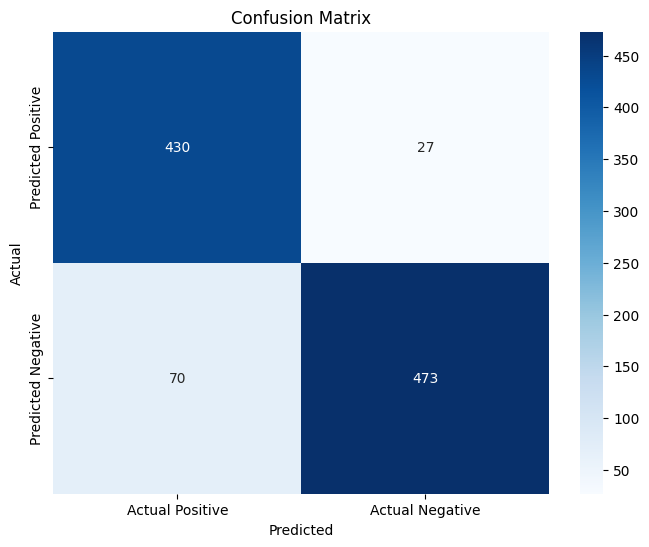

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(confusion_matrix):
    labels = ['Actual Positive', 'Actual Negative']
    categories = ['Predicted Positive', 'Predicted Negative']

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=categories)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Example confusion matrix
confusion_matrix = np.array([[TP, FP], [FN, TN]])

# Plot the confusion matrix
plot_confusion_matrix(confusion_matrix)

1/1 [==============================] - 0s 118ms/step


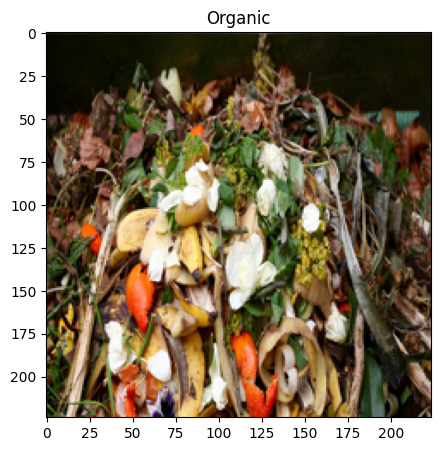

In [39]:
import numpy as np
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import load_model
import tensorflow as tf
import numpy as np
from PIL import Image


# Load and preprocess the image
image_path = '/content/sample_data/OrganicWaste.png'
image = Image.open(image_path)
image = image.resize((224, 224))  # Resize the image to match your model's input size
image = np.array(image)
image = image / 255.0  # Normalize pixel values to the range of [0, 1]
im = np.expand_dims(image, axis=0)  # Add a batch dimension


predictions1=(model.predict(im) > 0.5).astype("int32")
#print(predictions1)
predictions1 = predictions1.reshape(1,-1)[0]
#print(predictions1)

if (predictions1 == 0):
  plt.figure(figsize = (5,5))
  plt.imshow(image)
  plt.title('Organic')
elif (predictions1==1):
  plt.figure(figsize = (5,5))
  plt.imshow(image)
  plt.title('Recyclable')
